<a href="https://colab.research.google.com/github/yoba7/Geomatics/blob/master/bbox_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outils

## Imports

In [0]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from matplotlib.pyplot import imshow,show

In [0]:
device=torch.device("cuda")

## Fonction d'activation

Fonction d'activation utilisée dans le cadre du projet.

f(x)=\begin{cases}
    1 \text{ if}  l \leq x \leq u\\
    0 \text{ otherwise}
\end{cases}



In [0]:
Sigmoid=torch.nn.Sigmoid()

def myActivation(x,l,u):
    return Sigmoid(5*(x-l))+Sigmoid(5*(-x+u))-1

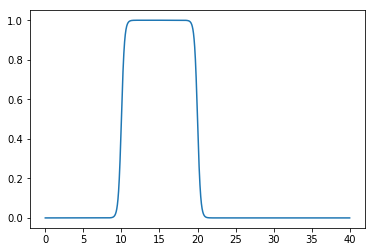

In [4]:
plt.plot([x/100 for x in range(4000)],[myActivation(x/100,torch.tensor(10,dtype=torch.float64),torch.tensor(20,dtype=torch.float64)) for x in range(4000)])

# Nuage de point

## Importation d'une image de test

In [0]:
#If you want to test with another image
#from google.colab import files
#uploaded = files.upload()

In [6]:
!wget  https://raw.githubusercontent.com/yoba7/Geomatics/master/images/rectangle-6.jpg

--2019-08-09 08:51:00--  https://raw.githubusercontent.com/yoba7/Geomatics/master/images/rectangle-6.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10442 (10K) [image/jpeg]
Saving to: ‘rectangle-6.jpg’

rectangle-6.jpg     100%[===================>]  10.20K  --.-KB/s    in 0s      

2019-08-09 08:51:06 (134 MB/s) - ‘rectangle-6.jpg’ saved [10442/10442]



In [0]:
imageDirectory='/content'

In [0]:
imageFile='rectangle-6.jpg'

In [0]:
def jpg2img(imageFile):
    img = cv2.imread('{}/{}'.format(imageDirectory,imageFile))
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return(hsv)

In [0]:
myImg=jpg2img(imageFile)

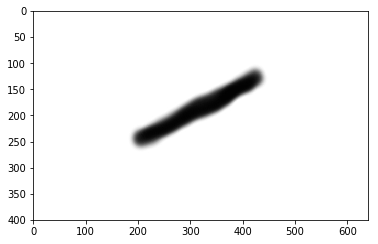

In [11]:
imshow(cv2.cvtColor(myImg, cv2.COLOR_HSV2RGB))

In [0]:
# Dimension de l'image

hauteur=400
largeur=640

## Transformation de l'image en matrice de 1s et de 0s

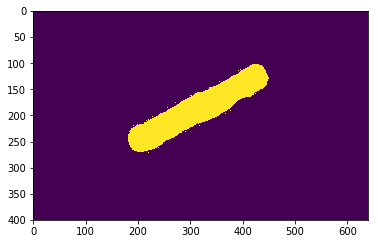

In [13]:
# Transformation de l'image en Matrice de 1s et de 0s

myValue = torch.from_numpy((myImg[:,:,2]<255).astype(float))

imshow(myValue)

## Bounding box

In [0]:
myMin=np.amin(np.where(myValue==1),axis=1)
myMax=np.amax(np.where(myValue==1),axis=1)

In [15]:
# Envoyer la matrice vers le GPU

myValue=myValue.to(device,dtype=torch.float64)
myValue.sum()

tensor(14763., device='cuda:0', dtype=torch.float64)

In [0]:
angle=torch.tensor(0,dtype=torch.float64)

l1 = torch.tensor(  myMin[0] , requires_grad=True,device=device,dtype=torch.float64)
u1 = torch.tensor(  myMax[0] , requires_grad=True,device=device,dtype=torch.float64)

l2 = torch.tensor(  myMin[1] , requires_grad=True,device=device,dtype=torch.float64)
u2 = torch.tensor(  myMax[1] , requires_grad=True,device=device,dtype=torch.float64)

In [0]:
X=torch.ones(hauteur,1,dtype=torch.float64,device=device).mm(torch.reshape(torch.arange(largeur,dtype=torch.float64,device=device),(1,largeur)))
Y=torch.reshape(torch.arange(hauteur,dtype=torch.float64,device=device),(hauteur,1)).mm(torch.ones(1,largeur,dtype=torch.float64,device=device))

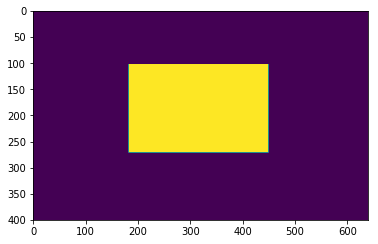

In [18]:
imshow(((myActivation(torch.sin(angle)*X+torch.cos(angle)*Y,l1,u1)*myActivation( torch.cos(angle)*X-torch.sin(angle)*Y,l2,u2))).cpu().detach().numpy())

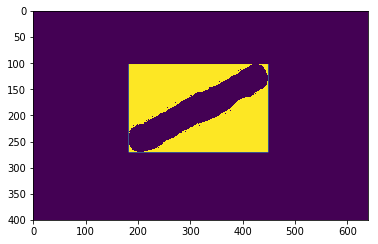

In [19]:
imshow((((myActivation(torch.sin(angle)*X+torch.cos(angle)*Y,l1,u1)*myActivation( torch.cos(angle)*X-torch.sin(angle)*Y,l2,u2))-myValue).pow(2)).cpu().detach().numpy())

# Trouver un rectangle qui entoure "au mieux" le nuage de point

## Description du problème

Soit un nuage de point de forme "à peu près rectangulaire. Il faut trouver un "rectangle" qui couvre au mieux le nuage de point. La dernière image de cette section représente un rectangle qui recouvre partiellement le nuage de point. L'idée est de déplacer et redimensionner ce rectangle de manière qu'il recouvre le "mieux possible", le nuage de point.

In [0]:
angle=torch.tensor(0.25, requires_grad=True,device=device,dtype=torch.float64)

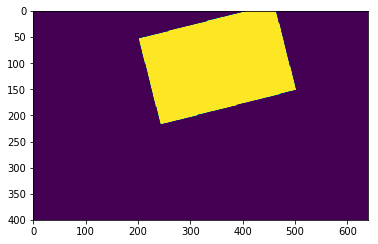

In [21]:
imshow(((myActivation(torch.sin(angle)*X+torch.cos(angle)*Y,l1,u1)*myActivation( torch.cos(angle)*X-torch.sin(angle)*Y,l2,u2))).cpu().detach().numpy())

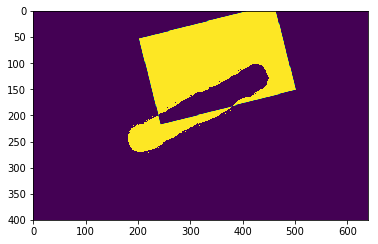

In [22]:
imshow((((myActivation(torch.sin(angle)*X+torch.cos(angle)*Y,l1,u1)*myActivation( torch.cos(angle)*X-torch.sin(angle)*Y,l2,u2))-myValue).pow(2)).cpu().detach().numpy())

## Calculs avec Pytorch

Trouver [angle,l1,u1,l2,u2] qui permettent de positionner au mieux le rectangle sur le nuage de points.

Iter:0-Objectif:160169.2435-(l1,u1):( 102.100, 271.100)-(l2,u2):( 182.100, 448.900)-angle: 0.1500


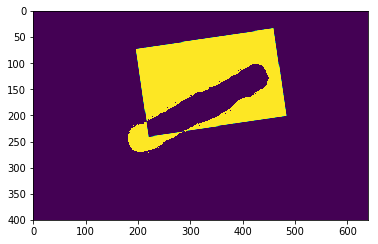

Iter:250-Objectif:117788.1561-(l1,u1):( 115.765, 267.841)-(l2,u2):( 178.996, 444.142)-angle: 0.0222


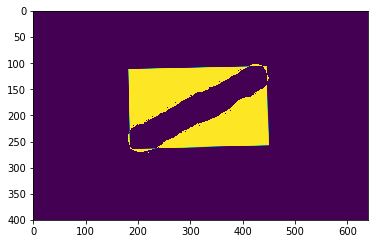

Iter:500-Objectif:116212.4780-(l1,u1):( 130.703, 275.611)-(l2,u2):( 169.420, 438.919)-angle: 0.0545


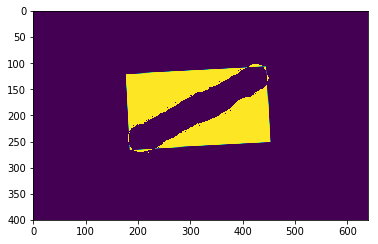

Iter:750-Objectif:113909.8355-(l1,u1):( 150.793, 285.301)-(l2,u2):( 156.442, 430.801)-angle: 0.1059


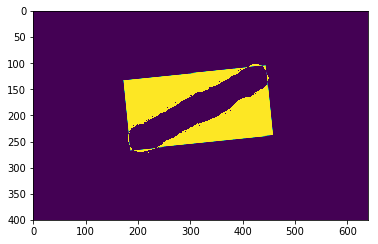

Iter:1000-Objectif:110740.0226-(l1,u1):( 175.056, 296.314)-(l2,u2):( 139.143, 419.773)-angle: 0.1664


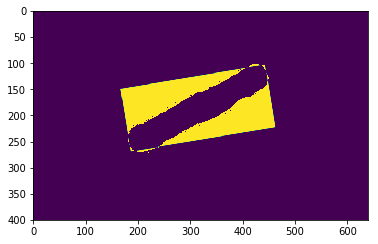

Iter:1250-Objectif:106832.9798-(l1,u1):( 202.037, 308.118)-(l2,u2):( 119.584, 405.453)-angle: 0.2353


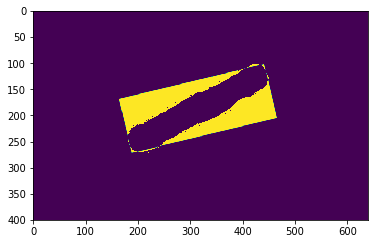

Iter:1500-Objectif:102344.5855-(l1,u1):( 229.163, 318.807)-(l2,u2):(  98.044, 388.416)-angle: 0.3083


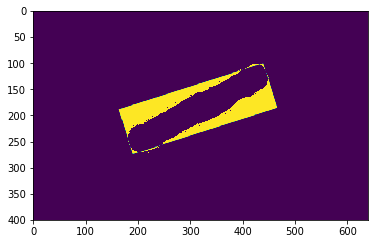

Iter:1750-Objectif:97581.2453-(l1,u1):( 255.285, 327.865)-(l2,u2):(  75.176, 368.932)-angle: 0.3907


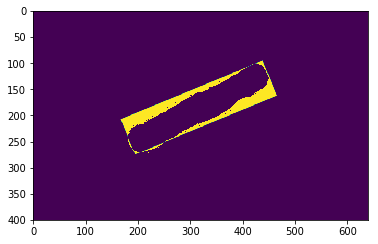

Iter:2000-Objectif:94465.9115-(l1,u1):( 276.384, 339.100)-(l2,u2):(  52.398, 350.633)-angle: 0.4641


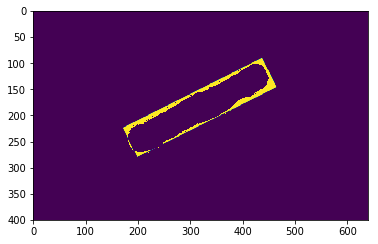

Iter:2250-Objectif:92384.4233-(l1,u1):( 284.569, 340.900)-(l2,u2):(  43.889, 341.750)-angle: 0.4743


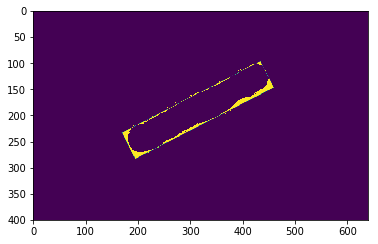

In [23]:
learning_rate=0.1

poidsPointsMaison=640*400/myValue.sum()/5

optimizer = torch.optim.Adam([angle,l1,u1,l2,u2], lr=learning_rate)

prec=1E9

for loop in range(2500):    
        
    objectif= (
               (
                 myActivation(torch.sin(angle)*X+torch.cos(angle)*Y,l1,u1)
                 *
                 myActivation(torch.cos(angle)*X-torch.sin(angle)*Y,l2,u2)
                )-myValue*poidsPointsMaison
               ).pow(2).sum()
    
    optimizer.zero_grad()
    objectif.backward()
    optimizer.step()
        
    if loop%250==0:
        print("Iter:{}-Objectif:{:10.4f}-(l1,u1):({:8.3f},{:8.3f})-(l2,u2):({:8.3f},{:8.3f})-angle:{:7.4f}".format(
                loop,objectif.item(),l1,u1,l2,u2,angle))
        imshow((((myActivation(torch.sin(angle)*X+torch.cos(angle)*Y,l1,u1)*myActivation( torch.cos(angle)*X-torch.sin(angle)*Y,l2,u2))-myValue)**2).cpu().detach().numpy())
        show()
          
    if loop>100:
        if abs((objectif.item()-prec)/prec)<1E-8:
            print("Convergence")
            print("Iter:{}-Objectif:{:10.4f}-(l1,u1):({:8.3f},{:8.3f})-(l2,u2):({:8.3f},{:8.3f})-angle:{:7.4f}".format(
                loop,objectif.item(),l1,u1,l2,u2,angle))
            break
        
    prec=objectif.item()
    

        

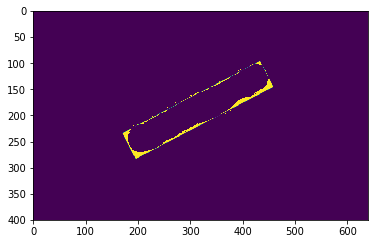

In [24]:
# Visualiser le résultat

imshow((((myActivation(torch.sin(angle)*X+torch.cos(angle)*Y,l1,u1)*myActivation( torch.cos(angle)*X-torch.sin(angle)*Y,l2,u2))-myValue)**2).cpu().detach().numpy())
show()

## Trouver les coordonnées des coins du rectange

In [0]:
a = np.array([
              [ torch.sin(angle).item(),   torch.cos(angle).item()], 
              [ torch.cos(angle).item(),  -torch.sin(angle).item()]
             ])

b1 = np.array([l1.item(),l2.item()])
b2 = np.array([l1.item(),u2.item()])
b3 = np.array([u1.item(),u2.item()])
b4 = np.array([u1.item(),l2.item()])

x1 = np.linalg.solve(a, b1)
x2 = np.linalg.solve(a, b2)
x3 = np.linalg.solve(a, b3)
x4 = np.linalg.solve(a, b4)

## Visualiser le polygone

Utiliser les coordonnées des coins pour construire un polygone (rectangle)

In [0]:
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

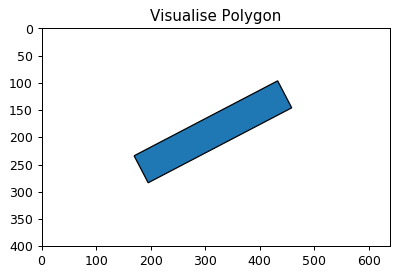

In [27]:
# See https://deparkes.co.uk/2015/03/11/how-to-plot-polygons-in-python/

fig = plt.figure(1, figsize=(5,5), dpi=90)
ring_mixed = Polygon([x1,x2,x3,x4,x1])
ax = fig.add_subplot(111)
ring_patch = PolygonPatch(ring_mixed)
ax.add_patch(ring_patch)
ax.set_title('Visualise Polygon')
xrange = [0, largeur]
yrange = [0, hauteur]
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect(1)
plt.gca().invert_yaxis()